The purpose of this study is to propose a prediction model for 30-day unplanned readmission among diabetes patients in US hospitals. The analysis will be based on risk factors such as a patient’s demographics, admission details, diagnosis, and medical data. In a broader sense, the goal of the study is to allow health centers to better anticipate and address unplanned readmissions while improving their quality of care and cost efficiency.

### Import Libraries

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import dataset

In [111]:
df = pd.read_csv('diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Data exploration and Cleaning
Cleaning tasks such as dropping bad data, dealing with missing values.

In [112]:
df.shape

(101766, 50)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

There are 50 features in this data. It conatins numerical values(int) and categorical values(object).

There are 101766 samples present in this dataset. There seem to be no null values.We will dig deep and find out more.

In [114]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


There are 50 features looking into all of these.

1. encounter_id : unique identifier of an encounter

In [115]:
df['encounter_id'].nunique()

101766

All the patients that have come to the hospital have been provided with an encounter_id so that is why there are 101766 different unique values.

2. patient_nbr : unique identifier of a patient

In [116]:
df['patient_nbr'].nunique()

71518

There are 71518 unique paitents that have entered the system.

#encounter_id and patient_nbr: these are just identifiers and not useful variables so they can be dropped

In [117]:
df = df.drop(columns=['encounter_id', 'patient_nbr'])

3. race : It is a categorical variable.

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64


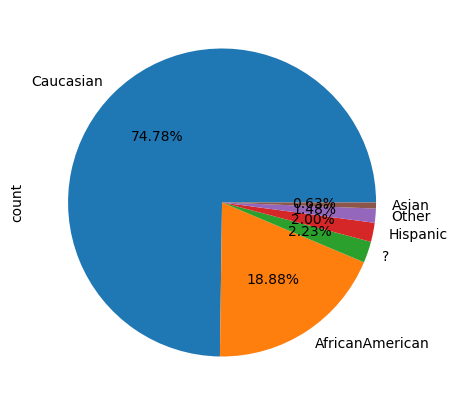

In [118]:
print(df['race'].value_counts())
df['race'].value_counts().plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.show()

There are 5 distinct categories under race feature. There are some unknown values here entered in the form of '?' which needs to be treated.

In [119]:
df['race'] = df['race'].replace('?',np.nan)
df['race'].isna().sum()*100/df.shape[0]
# Only 2.3 % of null values in column 'race'

2.2335554114340743

For null value filling we dropped the null values as mull values set are very less.

In [120]:
df = df[df['race'].notna()]


4. gender: It is a categorical feature depicting the gender of the patient.

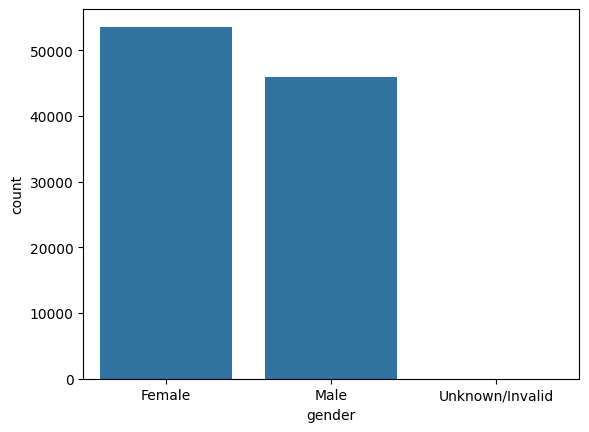

gender
Female             53575
Male               45917
Unknown/Invalid        1
Name: count, dtype: int64


In [121]:
sns.countplot(x='gender',data=df)
plt.show()
print(df.gender.value_counts())

There are 2 categories here: female, male. There is a 3rd category of unknown/invalid which are missing/unknown values which only have 1 value hence they can be dropped.

In [122]:
df = df[df['gender'] != 'Unknown/Invalid']

In [123]:
#encoding gender
df['gender'] = df['gender'].replace({'Female' : 0, 'Male' : 1})

5. Age: It is a categorical feature as the age is grouped here in bins of 10 yrs

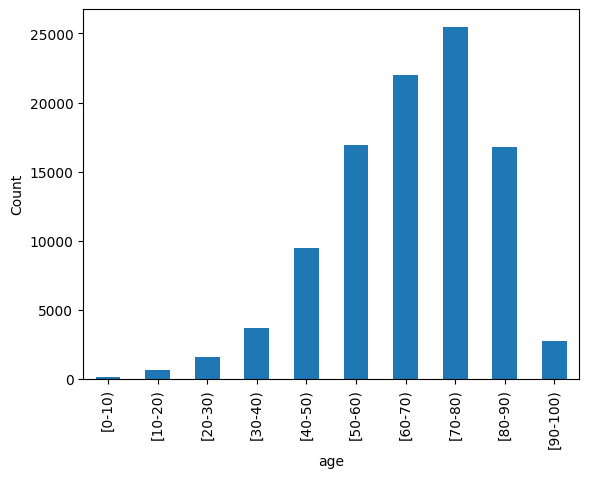

In [124]:
# check 'age' feature
df.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

The age here range from 0 to 100 yrs. 

The population falling in the range of 50 to 90 yrs are mostly present in this dataset.

Treating age column by taking the middle value

In [125]:
#Age
# Modify age column
df['age'] = df['age'].map({'[70-80)': 75,
                                       '[60-70)': 65,
                                       '[80-90)': 85,
                                       '[50-60)': 55,
                                       '[40-50)':45,
                                       '[30-40)': 35,
                                       '[90-100)':95,
                                       '[20-30)':25,
                                       '[10-20)':15,
                                       '[0-10)': 5})
df['age'].value_counts()

age
75    25468
65    21988
55    16895
85    16800
45     9465
35     3699
95     2724
25     1611
15      682
5       160
Name: count, dtype: int64

6. Weight : weight in pounds.

In [126]:
df.weight.value_counts(1)*100

weight
?            96.925381
[75-100)      1.285530
[50-75)       0.865396
[100-125)     0.599043
[125-150)     0.136694
[25-50)       0.093475
[0-25)        0.047240
[150-175)     0.034174
[175-200)     0.010051
>200          0.003015
Name: proportion, dtype: float64

Weight is also divided into bins of 25 pounds, but 96.9% part of the weight has unknown values. So we can drop this column.

In [127]:
df.drop(['weight'],axis=1,inplace=True)

7. admission_type_id : Integer identifier corresponding to 8 distinct values, for example, emergency, urgent, elective, newborn, and not available

In [128]:
df.admission_type_id.nunique()

8

There are 8 unique values ranging from 1 to 8. These 8 values correspond to : 

1	Emergency

2	Urgent

3	Elective

4	Newborn

5	Not Available

6	NULL

7	Trauma Center

8	Not Mapped

For further analysis we can merger these categories into less number of categories.

Emeregncy/Urgent/Trauma Center ---> Emergency 

Not Available/Null/Not Mapped ---> Not Available

Elective ---> Elective

New Born ---> New Born

In [129]:
df['admission_type_id']=df['admission_type_id'].replace({1:'Emergency',2:'Emergency',7:'Emergency',
                                 5:'Not Available', 6:'Not Available', 8:'Not Available',
                                 3:'Elective',4:'Newborn'})

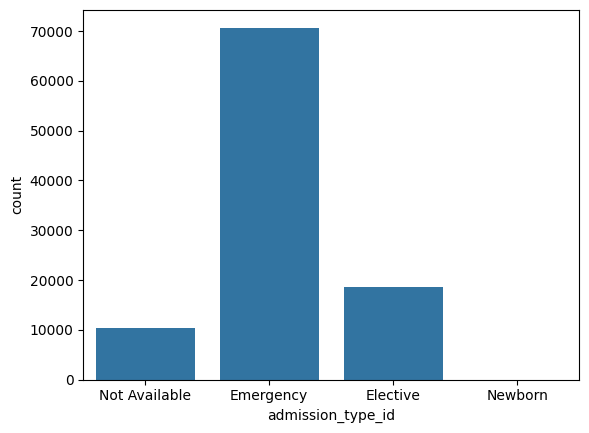

In [130]:
sns.countplot(x='admission_type_id',data=df)
plt.show()

From this we can see that the majority patients that have been admitted in this hospital have an admission type as emergency.

In [131]:
df[df['admission_type_id']== 'Newborn'][['gender','age','admission_type_id']]

,gender,age,admission_type_id
2043,1,55,Newborn
2203,1,85,Newborn
2461,1,75,Newborn
4823,0,65,Newborn
35877,1,65,Newborn
47548,1,45,Newborn
48711,0,75,Newborn
80354,0,5,Newborn
87714,1,65,Newborn
100721,1,85,Newborn


Droppping the category new born because the admission_type_id == newborn and the age and gender corresponding to it gives contradictory information.

In [132]:
df=df[df['admission_type_id']!='Newborn']

In [133]:
df.admission_type_id.value_counts()

admission_type_id
Emergency        70706
Elective         18507
Not Available    10269
Name: count, dtype: int64


8. Discharge disposition: Integer identifier corresponding to 26 distinct values, for example, discharged to home, expired, and not available

#### discharge_disposition_id	description

1	Discharged to home

2	Discharged/transferred to another short term hospital

3	Discharged/transferred to SNF(skilled nursing facility)

4	Discharged/transferred to ICF(intermediate care facility)

5	Discharged/transferred to another type of inpatient care institution

6	Discharged/transferred to home with home health service

7	Left AMA(Against Medical Advice.)

8	Discharged/transferred to home under care of Home IV provider

9	Admitted as an inpatient to this hospital

10	Neonate discharged to another hospital for neonatal aftercare

11	Expired

12	Still patient or expected to return for outpatient services

13	Hospice / home

14	Hospice / medical facility

15	Discharged/transferred within this institution to Medicare approved swing bed

16	Discharged/transferred/referred another institution for outpatient services

17	Discharged/transferred/referred to this institution for outpatient services

18	NULL

19	Expired at home. Medicaid only, hospice.

20	Expired in a medical facility. Medicaid only, hospice.

21	Expired, place unknown. Medicaid only, hospice.

22	Discharged/transferred to another rehab fac including rehab units of a hospital .

23	Discharged/transferred to a long term care hospital.

24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.

25	Not Mapped

26	Unknown/Invalid

30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere

27	Discharged/transferred to a federal health care facility.

28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital

29	Discharged/transferred to a Critical Access Hospital (CAH).

#### We can merge several grps over here to reduce the number of categories:

1 ---> Discharged to home

2/3/4/5/10/16/22/23/24/30/27/28/29 ---> Transferred to another medical facility

7 ---> Left AMA(Against Medical Advice.)

6/8 ---> Discharged to home with home health service

9/12/15/17 ---> Still patient/referred to this institution

11/19/20/21  ---> Expired

18/25/26 ---> Not Available

13/14 ---> Hospice

In [134]:
df['discharge_disposition_id']=df['discharge_disposition_id'].replace({1:'Discharged to home',
                                        2:'Transferred to another medical facility',
                                        3:'Transferred to another medical facility',
                                        4:'Transferred to another medical facility',
                                        5:'Transferred to another medical facility',
                                        16:'Transferred to another medical facility',
                                        22:'Transferred to another medical facility',
                                        23:'Transferred to another medical facility',
                                        24:'Transferred to another medical facility',
                                        27:'Transferred to another medical facility',
                                        28:'Transferred to another medical facility',
                                        29:'Transferred to another medical facility',
                                        30:'Transferred to another medical facility',                            
                                        6:'Discharged to home with home health service',
                                        8:'Discharged to home with home health service',
                                        7:'Left AMA',
                                        9:'Still patient/referred to this institution',
                                        12:'Still patient/referred to this institution',
                                        15:'Still patient/referred to this institution',
                                        17:'Still patient/referred to this institution',
                                        10:'Neonate discharged',
                                        11:'Expired',
                                        19:'Expired',
                                        20:'Expired',
                                        21:'Expired',
                                        13:'Hospice',
                                        14:'Hospice',
                                        18:'Not Available',
                                        25:'Not Available',
                                        26:'Not Available'})

In [135]:
df.discharge_disposition_id.value_counts()

discharge_disposition_id
Discharged to home                             58761
Transferred to another medical facility        20172
Discharged to home with home health service    12801
Not Available                                   4646
Expired                                         1618
Hospice                                          766
Left AMA                                         611
Still patient/referred to this institution       101
Neonate discharged                                 6
Name: count, dtype: int64

The patients who have expired should be removed from the system beacuse they will create bias as they will not be readmitted.

In [136]:
df=df[df['discharge_disposition_id']!='Expired']
df=df[df['discharge_disposition_id']!='Neonate discharged']
df=df[df['discharge_disposition_id']!='Hospice']

9. admission_source_id: Integer identifier corresponding to 17 distinct values, for example, physician referral, emergency room, and transfer from a hospital

In [137]:
df.admission_source_id.value_counts(sort=False)

admission_source_id
1     28456
7     55007
2      1021
4      2918
5       800
20      158
6      1964
3       185
17     6489
8        15
9        54
10        7
22       12
14        1
11        2
25        2
13        1
Name: count, dtype: int64


1	 Physician Referral

2	Clinic Referral

3	HMO Referral(Health Maintenance Organization)

4	Transfer from a hospital

5	 Transfer from a Skilled Nursing Facility (SNF)

6	 Transfer from another health care facility

7	 Emergency Room

8	 Court/Law Enforcement

9	 Not Available

10	 Transfer from critial access hospital

11	Normal Delivery

12	 Premature Delivery

13	 Sick Baby

14	 Extramural Birth

15	Not Available

17	NULL

18	 Transfer From Another Home Health Agency

19	Readmission to Same Home Health Agency

20	 Not Mapped

21	Unknown/Invalid

22	 Transfer from hospital inpt/same fac reslt in a sep claim

23	 Born inside this hospital

24	 Born outside this hospital

25	 Transfer from Ambulatory Surgery Center

26	Transfer from Hospice

#### We can merge several grps over here to reduce the number of categories:

1/2/3 ---> Referral

4/5/6/10/18/19/25/26/22 ---> Transferred from another health care facility

7 ---> Emergency

9/15/17/20/21 ---> Not Available

8 --->  Court/Law Enforcement

Delivery ---> 11/12/14/13/23/24

In [138]:
df['admission_source_id']=df['admission_source_id'].replace({1:'Referral',
                                   2:'Referral',
                                   3:'Referral',
                                   4:'Transferred from another health care facility',
                                   5:'Transferred from another health care facility',
                                   6:'Transferred from another health care facility',
                                   8:'Emergency',                                    
                                   10:'Transferred from another health care facility',
                                   18:'Transferred from another health care facility',
                                   19:'Transferred from another health care facility',
                                   25:'Transferred from another health care facility',
                                   26:'Transferred from another health care facility',
                                   7:'Emergency',
                                   9:'Not Available',
                                   15:'Not Available',
                                   17:'Not Available',
                                   20:'Not Available',
                                   21:'Not Available',
                                   11:'Delivery',
                                   12:'Delivery',
                                   13:'Delivery',
                                   14:'Delivery',
                                   23:'Delivery',
                                   22:"Transferred from another health care facility",                                    
                                   24:'Delivery'})

In [139]:
df.admission_source_id.value_counts()

admission_source_id
Emergency                                        55022
Referral                                         29662
Not Available                                     6701
Transferred from another health care facility     5703
Delivery                                             4
Name: count, dtype: int64

In [140]:
df[df['admission_source_id']=='Delivery'][['gender','age','admission_source_id']]

,gender,age,admission_source_id
83432,0,75,Delivery
83510,0,25,Delivery
85588,0,75,Delivery
97384,1,75,Delivery


Droping the category delivery  because the admission_source_id == delivery and the age corresponding to it give contradictory information.

In [141]:
df=df[df['admission_source_id']!='Delivery']

* Since we have 2 columns regarding admission, type_id and source_id, we used this information to fill the ‘Not Available’ values in admssion_source_id columns with respect to the admission_type_id. For example, if admission_type_id is Emergency but admission_source_id is Not Available, we can fill Emergency(mode) in that place.
* After filling it admission_type_id column was dropped since it was giving the same information as admission_source_id and was less significant statistically. 

In [142]:
df = df.reset_index(drop = True )

In [143]:
# Before
df[df['admission_type_id']=='Emergency']['admission_source_id'].value_counts()

admission_source_id
Emergency                                        52268
Referral                                         11094
Transferred from another health care facility     4422
Not Available                                      981
Name: count, dtype: int64

In [144]:
for i in range(df.shape[0]):
    if df.loc[i, 'admission_source_id'] == 'Not Available' and df.loc[i, 'admission_type_id'] == 'Emergency':
        df.loc[i, 'admission_source_id'] = 'Emergency'

In [145]:
# After
df[df['admission_type_id']=='Emergency']['admission_source_id'].value_counts()

admission_source_id
Emergency                                        53249
Referral                                         11094
Transferred from another health care facility     4422
Name: count, dtype: int64

In [146]:
# Before
df[df['admission_type_id']=='Elective']['admission_source_id'].value_counts()

admission_source_id
Referral                                         16128
Transferred from another health care facility     1211
Emergency                                          912
Not Available                                       59
Name: count, dtype: int64

In [147]:
for i in range(df.shape[0]):
    if df.loc[i, 'admission_source_id'] == 'Not Available' and df.loc[i, 'admission_type_id'] == 'Elective':
        df.loc[i, 'admission_source_id'] = 'Referral'

In [148]:
# After
df[df['admission_type_id']=='Elective']['admission_source_id'].value_counts()

admission_source_id
Referral                                         16187
Transferred from another health care facility     1211
Emergency                                          912
Name: count, dtype: int64

10. Time in hospital: Integer number of days between admission and discharge

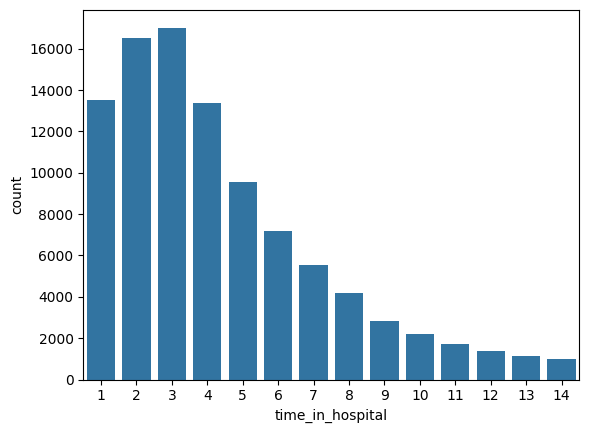

In [149]:
sns.countplot(x='time_in_hospital',data=df)
plt.show()

The time in the hospital ranges from 1 day to 14 days.

11. payer_code : Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical

In [150]:
df.payer_code.value_counts(1)*100

payer_code
?     40.020394
MC    31.427159
HM     6.230430
SP     4.843029
BC     4.621580
MD     3.475198
CP     2.468894
UN     2.314395
CM     1.916818
OG     1.033083
PO     0.599456
DM     0.545897
CH     0.144199
WC     0.128749
OT     0.094759
MP     0.079309
SI     0.056650
Name: proportion, dtype: float64

Payer code has a significant number (approx. 40% )of missing values and it are not signification w.r.t the patient readmission so we can drop it.

In [151]:
df.drop(['payer_code'],axis=1,inplace=True)

12. medical_specialty: Integer identifier of a specialty of the admitting physician, corresponding to 73 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon

In [152]:
df.medical_specialty.nunique()

73

In [153]:
df.medical_specialty.value_counts(1)*100

medical_specialty
?                                       48.869067
InternalMedicine                        14.215969
Emergency/Trauma                         7.616801
Family/GeneralPractice                   7.296473
Cardiology                               5.330216
Surgery-General                          3.092040
Nephrology                               1.564560
Orthopedics                              1.410061
Orthopedics-Reconstructive               1.222602
Radiologist                              1.130933
Psychiatry                               0.852835
Pulmonology                              0.847685
Urology                                  0.687006
ObstetricsandGynecology                  0.666406
Surgery-Cardiovascular/Thoracic          0.637566
Gastroenterology                         0.550016
Surgery-Vascular                         0.540747
Surgery-Neuro                            0.462467
PhysicalMedicineandRehabilitation        0.393457
Oncology                        

There are 73 unique values here and a 48.8% of values are missing ('?') hence we drop this column.

In [154]:
df.drop(['medical_specialty'],axis=1,inplace=True)

13. num_lab_procedures: Number of lab tests performed during the encounter

In [155]:

print('The number of lab tests a patient has undergone can range from',df.num_lab_procedures.min(),'to',df.num_lab_procedures.max())

The number of lab tests a patient has undergone can range from 1 to 132


14. num_procedures: Number of procedures(other than lab tests) performed during the encounter

In [156]:
df.num_procedures.value_counts()

num_procedures
0    44532
1    19843
2    12140
3     9032
6     4675
4     3970
5     2896
Name: count, dtype: int64

No of procedures range from 0 to 5

15. num_medications: Number of distinct generic names administered during the encounter

In [157]:
print('The number of medications range from a minimum of',df.num_medications.min(),'to maximum of',df.num_medications.max())

The number of medications range from a minimum of 1 to maximum of 81


16. number_outpatient: Number of outpatient visits of the patient in the year preceding the encounter 

17. number_emergency : Number of emergency visits of the patient in the year preceding the encounter

18. number_inpatient: Number of inpatient visits of the patient in the year preceding the encounter 

19. Diagnosis1: The primary diagnosis(coded as first three digits of ICD9) 

20. Diagnosis2: Secondary diagnosis(coded as first three digits of ICD9)

21. Diagnosis3: Additional secondary diagnosis(coded as first three digits of ICD9)

In [158]:
df = df.reset_index(drop = True )

In [159]:
diag_cols = ['diag_1','diag_2','diag_3']

In [160]:
ord('E'), ord('V')

(69, 86)

In [161]:
for i in diag_cols:
    for j in range(len(df[i])):
        if str(df.loc[j, i])[:3] == '250':
            df.loc[j, i] = 'Diabetes'
        elif ord(str(df.loc[j, i])[0]) in range(69, 87):
            df.loc[j, i] = 'External causes of injury'
        elif df.loc[j, i] == '?':
            df.loc[j, i] = 'Missing'
        else:
            x = float(df.loc[j, i])
            if x in range(390, 460) or x == 785:
                df.loc[j, i] = 'Circulatory'
            elif x in range(460, 520) or x == 786:
                df.loc[j, i] = 'Respiratory'
            elif x in range(520, 580) or x == 787:
                df.loc[j, i] = 'Digestive'
            elif x in range(800, 1000):
                df.loc[j, i] = 'Injury and Poisoning'
            elif x in range(710, 740):
                df.loc[j, i] = 'Musculoskeletal System and Connective Tissue'
            elif x in range(580, 630) or x == 788:
                df.loc[j, i] = 'Genitourinary'
            elif x in range(140, 230):
                df.loc[j, i] = 'Neoplasms'
            elif x in [780, 781, 784] or x in range(790, 800):
                df.loc[j, i] = 'Other Symptoms'
            elif x in range(240, 280):
                df.loc[j, i] = 'Endocrine, Nutritional, Metabolic, Immunity'
            elif x in range(680, 710) or x == 782:
                df.loc[j, i] = 'Skin and Subcutaneous Tissue'
            elif x in range(1, 140):
                df.loc[j, i] = 'Infectious and Parasitic'
            elif x in range(290, 320):
                df.loc[j, i] = 'Mental Disorders'
            elif x in range(280, 290):
                df.loc[j, i] = 'Blood and Blood-Forming Organs'
            elif x in range(320, 360):
                df.loc[j, i] = 'Nervous'
            elif x in range(630, 680):
                df.loc[j, i] = 'Pregnancy, Childbirth'
            elif x in range(360, 390):
                df.loc[j, i] = 'Sense Organs'
            else:
                df.loc[j, i] = 'Congenital Anomalies'

In [162]:
for i in range(len(df['diag_2'])):
    if df.loc[i, 'diag_2'] == 'Missing':
        if df.loc[i, 'diag_1'] != 'Missing':
            df.loc[i, 'diag_2'] = 'Not Required'

In [163]:
for i in range(len(df['diag_3'])):
    if df.loc[i, 'diag_3'] == 'Missing':
        if df.loc[i, 'diag_2'] == 'Not Required' or df.loc[i, 'diag_2'] != 'Missing':
            df.loc[i, 'diag_3'] = 'Not Required'

In [164]:
df1 = pd.DataFrame(df['diag_1'].value_counts())
df2 = df1.merge(pd.DataFrame(df['diag_2'].value_counts()), how = 'outer', left_index = True, right_index = True)
df2=df2.merge(pd.DataFrame(df['diag_3'].value_counts()), how = 'outer', left_index = True, right_index = True)

In [165]:
df2

,count_x,count_y,count
Blood and Blood-Forming Organs,1078.0,2801.0,2402.0
Circulatory,29004.0,30465.0,28956.0
Congenital Anomalies,791.0,478.0,467.0
Diabetes,8471.0,12392.0,16540.0
Digestive,9154.0,3994.0,3781.0
"Endocrine, Nutritional, Metabolic, Immunity",2553.0,7899.0,8726.0
External causes of injury,1595.0,2484.0,4938.0
Genitourinary,4912.0,8002.0,6289.0
Infectious and Parasitic,2487.0,1816.0,1773.0
Injury and Poisoning,6699.0,2302.0,1846.0


In [166]:
len(df[df['diag_1'] == 'Missing'])

18

In [167]:
#dropping any missing values present in diag_1.
df = df[df['diag_1'] != 'Missing']

23. number_diagnoses: Number of diagnoses entered to the system

<Axes: xlabel='number_diagnoses', ylabel='count'>

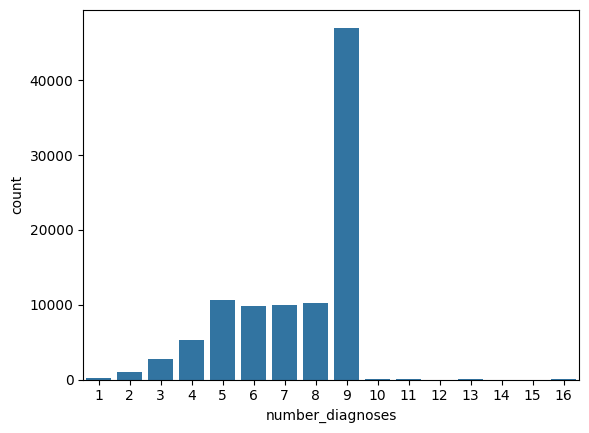

In [168]:
sns.countplot(x='number_diagnoses',data=df)

The number of diagonses entered into the system range from 1 to 16.

23. max_glu_serum: Indicates the range of the result or if the test was not taken.

Values:“>200,”“>300,” “normal,”and“none” if not measured     


In [169]:
df.max_glu_serum.value_counts()

max_glu_serum
Norm    2517
>200    1397
>300    1178
Name: count, dtype: int64

24. A1Cresult: Indicates the range of the result or if the test was not taken.

In [170]:
df.A1Cresult.value_counts()

A1Cresult
>8      7881
Norm    4836
>7      3691
Name: count, dtype: int64

Values: “>8” if the result was greater than 8%
    
        “>7” if the result was greater than 7% but less than 8%
        
        “normal” if the result was less than 7%
        
        “none” if not measured.

24. features for medications :
    
For the generic names : metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone

The feature indicates whether the drug was prescribed or there was a change in the dosage.

Values: “up” if the dosage was increased during the encounter

        “down” if the dosage was decreased
        
        “steady” if the dosage did not change
        
        “no” if the drug was not prescribed

In [171]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for i in meds:
       print(i, df[i].unique())

metformin ['No' 'Steady' 'Up' 'Down']
repaglinide ['No' 'Up' 'Steady' 'Down']
nateglinide ['No' 'Steady' 'Down' 'Up']
chlorpropamide ['No' 'Steady' 'Down' 'Up']
glimepiride ['No' 'Steady' 'Down' 'Up']
acetohexamide ['No' 'Steady']
glipizide ['No' 'Steady' 'Up' 'Down']
glyburide ['No' 'Steady' 'Up' 'Down']
tolbutamide ['No' 'Steady']
pioglitazone ['No' 'Steady' 'Up' 'Down']
rosiglitazone ['No' 'Steady' 'Up' 'Down']
acarbose ['No' 'Steady' 'Up' 'Down']
miglitol ['No' 'Steady' 'Down' 'Up']
troglitazone ['No' 'Steady']
tolazamide ['No' 'Steady' 'Up']
examide ['No']
citoglipton ['No']
insulin ['No' 'Up' 'Steady' 'Down']
glyburide-metformin ['No' 'Steady' 'Down' 'Up']
glipizide-metformin ['No' 'Steady']
glimepiride-pioglitazone ['No' 'Steady']
metformin-rosiglitazone ['No']
metformin-pioglitazone ['No' 'Steady']


In [172]:
# We can drop examide, citoglipton and metformin-rosiglitazone as it is not prescribed to any patient.
df.drop(['examide', 'citoglipton','metformin-rosiglitazone'], axis = 1, inplace = True)

In [173]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone']

In [174]:
# The medicines can be encoded as below 
for i in meds:
    df[i] = df[i].replace({'No' : -2,
                           'Down' : -1,
                           'Steady' : 0,
                           'Up' : 1})

In [175]:
for i in meds:
    df[i] = df[i].astype('int64')

25. change :  Indicates if there was a change in diabetic medications (either dosage or generic name)

In [176]:
df.change.value_counts()

change
No    52046
Ch    45024
Name: count, dtype: int64

In [177]:
df['change'] = df['change'].replace({'No' : 0, 'Ch' : 1})

26. diabetesMed : Indicates if there was any diabetic medication prescribed.

In [178]:
df.diabetesMed.value_counts()

diabetesMed
Yes    74842
No     22228
Name: count, dtype: int64

In [179]:
df['diabetesMed'] = df['diabetesMed'].replace({'Yes' : 1, 'No' : 0})

27. readmitted: Outcome variable

The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not.

In [180]:
df.readmitted.value_counts()

readmitted
NO     50995
>30    34955
<30    11120
Name: count, dtype: int64

The outcome actually has < 30, > 30 and No Readmission categories.So w.r.t. our problem we will convert this into 2 categories i.e No readmission or readmission with in 30 days

In [181]:
df['readmitted'] = df['readmitted'].replace('>30', 'NO')
df['readmitted']= df['readmitted'].replace( {'NO': 0, '<30': 1} ).astype(int)

In [182]:
df.reset_index(drop = True, inplace = True)

### Creating New Features and Dropping Redundant Ones

#### 1. Preceding year visits:
‘number_outpatient’, ‘number_emergency’, ‘number_inpatient’ were combined together by adding them up to get total visits of the patient in the previous year and then dropping the combining features.


In [183]:
df['preceding_year_visits']=df['number_outpatient']+df['number_emergency']+df['number_inpatient']

In [184]:
# Dropping ‘number_outpatient’, ‘number_emergency’, ‘number_inpatient’
df = df.drop(columns=['number_outpatient', 'number_emergency','number_inpatient'])

#### 2. Number of Medicines Changes

In [185]:
df['number_changes'] = np.nan
for i in range(len(df)):
    n = 0
    for j in meds:
        if df.loc[i, j] == -1 or df.loc[i, j] == 1:
            n += 1
    df.loc[i, 'number_changes'] = n

In [186]:
df['number_changes'].value_counts()

number_changes
0.0    70599
1.0    25081
2.0     1279
3.0      106
4.0        5
Name: count, dtype: int64

**3. Number of diabetic medicine**

In [187]:
df['number_diab_meds'] = np.nan
for i in range(len(df)):
    n = 0
    for j in meds:
        if df.loc[i, j] != -2:
            n += 1
    df.loc[i, 'number_diab_meds'] = n
df.number_diab_meds=df.number_diab_meds.astype('int64')
df['number_diab_meds'].value_counts()

number_diab_meds
1    44940
0    22228
2    21038
3     7504
4     1298
5       57
6        5
Name: count, dtype: int64

#### 4. Insulin_treatment

In [188]:
df['insulin_treatment'] = np.nan

In [189]:
for i in range(len(df)):
    if df.loc[i, 'insulin'] != -2 and df.loc[i, 'number_diab_meds'] == 1:
        df.loc[i, 'insulin_treatment'] = 'insulin_only'
    elif df.loc[i, 'insulin'] != -2 and df.loc[i, 'number_diab_meds'] > 1:
        df.loc[i, 'insulin_treatment'] = 'insulin_combo'
    elif df.loc[i, 'insulin'] == -2 and df.loc[i, 'number_diab_meds'] == 0:
        df.loc[i, 'insulin_treatment'] = 'no_med'
    else:
        df.loc[i, 'insulin_treatment'] = 'other_meds'
df['insulin_treatment'].value_counts()

insulin_treatment
insulin_only     29118
other_meds       23259
insulin_combo    22465
no_med           22228
Name: count, dtype: int64

In [190]:
# number_diab_meds was inly created to make the column insulin treatment, Hence we drop it
df = df.drop(columns=['number_diab_meds'])
df.reset_index(drop = True, inplace = True)

### Statistical tests 

In [191]:
# Numerical features
num_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
            'number_diagnoses','preceding_year_visits', 'number_changes']

In [192]:
# Categorical features
cat_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
            'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
            'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
            'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
            'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
            'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 
            'change', 'diabetesMed', 'insulin_treatment']

In [193]:
df.shape

(97070, 42)

In [194]:
len(num_cols)+len(cat_cols)

42

#### Chi Square for categorical v/s categorical and one way anova for categorical v/s numerical

To see if the features are significant w.r.t to the target variable (readmitted)

In [195]:
#Statistical Tests (Chi Square and Anova)

p_val = []
sig = []
for i in df.columns:
    if i in num_cols:
        stat, p = stats.f_oneway(df[df['readmitted'] == 0][i], df[df['readmitted'] == 1][i])
    else:
        ct = pd.crosstab(df[i], df['readmitted'])
        stat, p, dof, exp = stats.chi2_contingency(ct)
    p_val.append(p)
    if p < 0.05:
        sig.append('Significant')
    else:
        sig.append("Insignificant")
stats_df = pd.DataFrame({"columns" : df.columns, "p_value" : p_val, "significance" : sig})

stats_df.sort_values(by='p_value',ascending = True)

,columns,p_value,significance
39,preceding_year_visits,0.000000e+00,Significant
38,readmitted,0.000000e+00,Significant
4,discharge_disposition_id,1.002865e-175,Significant
13,number_diagnoses,1.181113e-62,Significant
6,time_in_hospital,6.893070e-49,Significant
31,insulin,1.450024e-43,Significant
9,num_medications,1.128847e-39,Significant
41,insulin_treatment,1.750135e-39,Significant
40,number_changes,3.627420e-30,Significant
12,diag_3,5.426864e-30,Significant


In [196]:
sig_cols = stats_df[stats_df['significance'] == 'Significant']['columns'].reset_index(drop = True)
insig_cols = stats_df[stats_df['significance'] == 'Insignificant']['columns'].reset_index(drop = True)
print('Statiscally significant features are :','\n')
print(sig_cols)
# Drop insignificant columns from the dataframe
df = df.drop(columns=insig_cols)

Statiscally significant features are : 

0                          age
1            admission_type_id
2     discharge_disposition_id
3          admission_source_id
4             time_in_hospital
5           num_lab_procedures
6               num_procedures
7              num_medications
8                       diag_1
9                       diag_2
10                      diag_3
11            number_diagnoses
12               max_glu_serum
13                   metformin
14                 repaglinide
15                 glimepiride
16                   glipizide
17                pioglitazone
18                     insulin
19                      change
20                 diabetesMed
21                  readmitted
22       preceding_year_visits
23              number_changes
24           insulin_treatment
Name: columns, dtype: object


In [197]:
#statistically insignificant meds

insignificant_meds = ['nateglinide','chlorpropamide','acetohexamide','tolbutamide','acarbose','miglitol',
                      'troglitazone','tolazamide','glyburide-metformin','glipizide-metformin',
                      'glimepiride-pioglitazone','metformin-pioglitazone','glyburide','rosiglitazone']

#### Looking for medicines

In [198]:
#looking at meds seperately

meds = ['metformin','repaglinide', 'glimepiride', 'glipizide','pioglitazone','insulin']

len(meds)

6

In [199]:
less_counts = []

for i in meds:
    print(df[i].value_counts(), '\n')

    vc = df[i].value_counts().values
    if vc[1:].sum() / vc[0:].sum() < 0.01:
        less_counts.append(i)
    else:
        print(vc[1:].sum() / vc[0:].sum())

metformin
-2    77697
 0    17777
 1     1035
-1      561
Name: count, dtype: int64 

0.19957762439476667
repaglinide
-2    95562
 0     1359
 1      106
-1       43
Name: count, dtype: int64 

0.015535180797362729
glimepiride
-2    92105
 0     4466
 1      316
-1      183
Name: count, dtype: int64 

0.051148655609354075
glipizide
-2    84827
 0    10963
 1      748
-1      532
Name: count, dtype: int64 

0.12612547646028638
pioglitazone
-2    89970
 0     6758
 1      226
-1      116
Name: count, dtype: int64 

0.07314309261357783
insulin
-2    45487
 0    29118
-1    11735
 1    10730
Name: count, dtype: int64 

0.5314000206036881


In [200]:
less_counts, len(less_counts) 

([], 0)

We cannot remove a single medicine as they are given more than 1% of the population 

Change and number change are depicting the same information and both of them are significant,we are dropping one of it based on the fact that number of change is a bit more significant than change.(lessser the pvalue better it is)

In [201]:
df = df.drop(['change'],axis=1)

In [202]:
df['admission_type_id'].value_counts()

admission_type_id
Emergency        68753
Elective         18305
Not Available    10012
Name: count, dtype: int64

In [203]:
df['admission_source_id'].value_counts()

admission_source_id
Emergency                                        55994
Referral                                         29712
Transferred from another health care facility     5703
Not Available                                     5661
Name: count, dtype: int64

admission sorce id and admission type id are similar as admission type id's details are present in admission source id so we can drop admission type id and just keep admission source id

In [204]:
df = df.drop(['admission_type_id'],axis=1)

In [205]:
df.shape

(97070, 23)

In [206]:
df.columns

Index(['age', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'metformin', 'repaglinide', 'glimepiride', 'glipizide',
       'pioglitazone', 'insulin', 'diabetesMed', 'readmitted',
       'preceding_year_visits', 'number_changes', 'insulin_treatment'],
      dtype='object')


## Multi-Collinearity


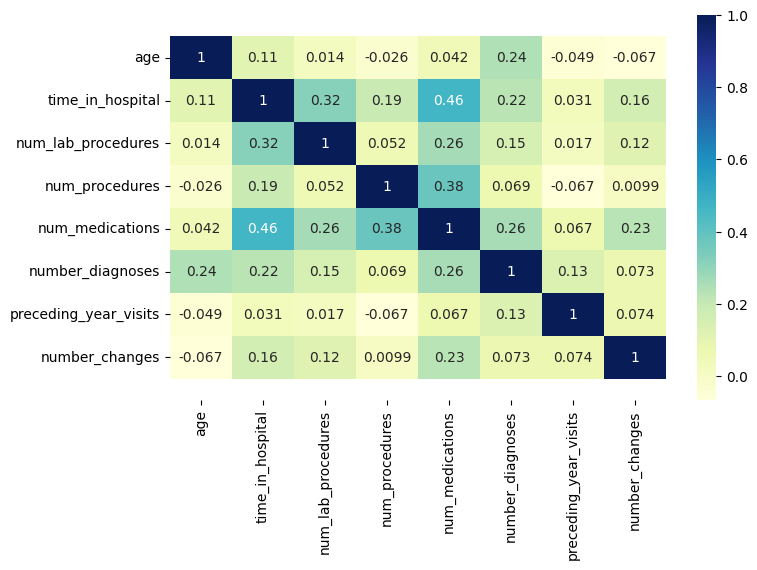

In [207]:
plt.figure(figsize=(8,5))
corr=df[num_cols].corr()
sns.heatmap(corr,annot=True,cmap='YlGnBu')
b,t=plt.ylim()
plt.ylim(b+0.5,t-0.5)
plt.show()

In [208]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(df[num_cols].values,i) for i in range(df[num_cols].shape[1])]
vif['feature']=df[num_cols].columns
vif=vif.sort_values('VIF',ascending=False)
vif

,VIF,feature
5,15.085635,number_diagnoses
0,12.141439,age
4,7.651632,num_medications
2,6.101781,num_lab_procedures
1,4.344960,time_in_hospital
3,1.926622,num_procedures
7,1.451683,number_changes
6,1.320692,preceding_year_visits


As it can be seen from correlation heatmap and vif values that there is high VIF value for number_diagnoses,so i would remove it

In [209]:
df.drop(columns=['number_diagnoses'], inplace=True)

In [210]:
# Rest of the Eda is done in tableau

## Outliers and Skewness

### Box-Plots

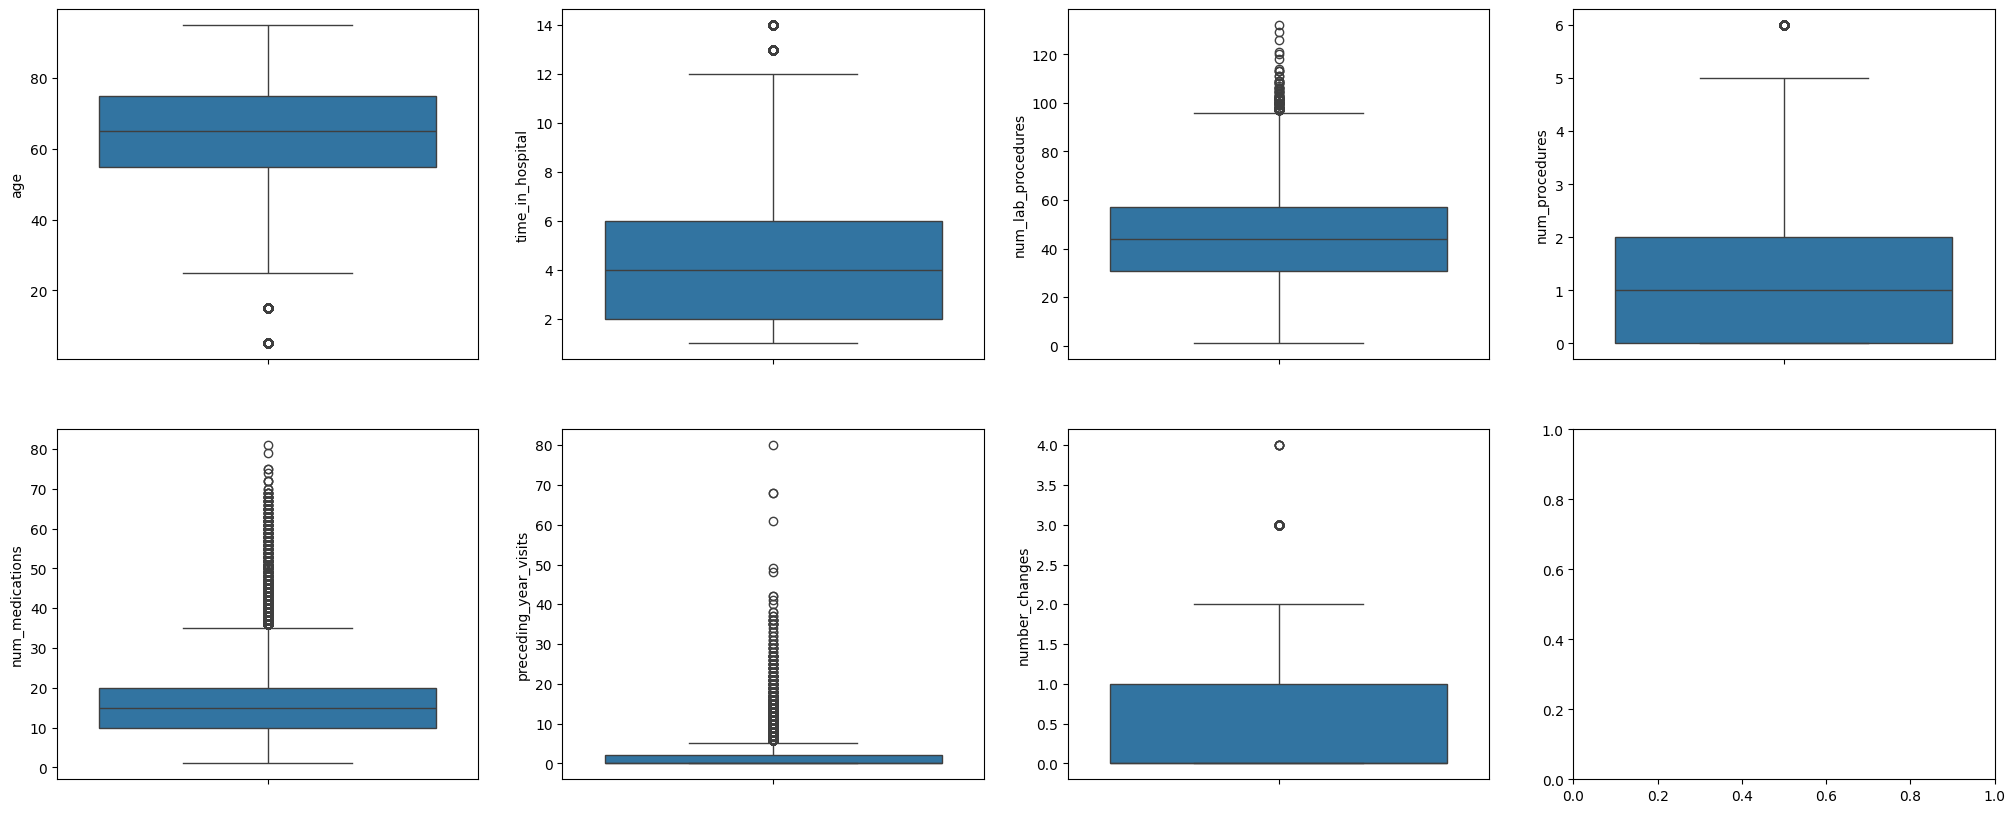

In [211]:
num_cols=num_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications','preceding_year_visits', 'number_changes']
fig,ax=plt.subplots(2,4,figsize=(25,10))
ax=ax.flatten()
j=0
for i in num_cols:    
    sns.boxplot(df[i],ax=ax[j]) 
    j=j+1
plt.show()

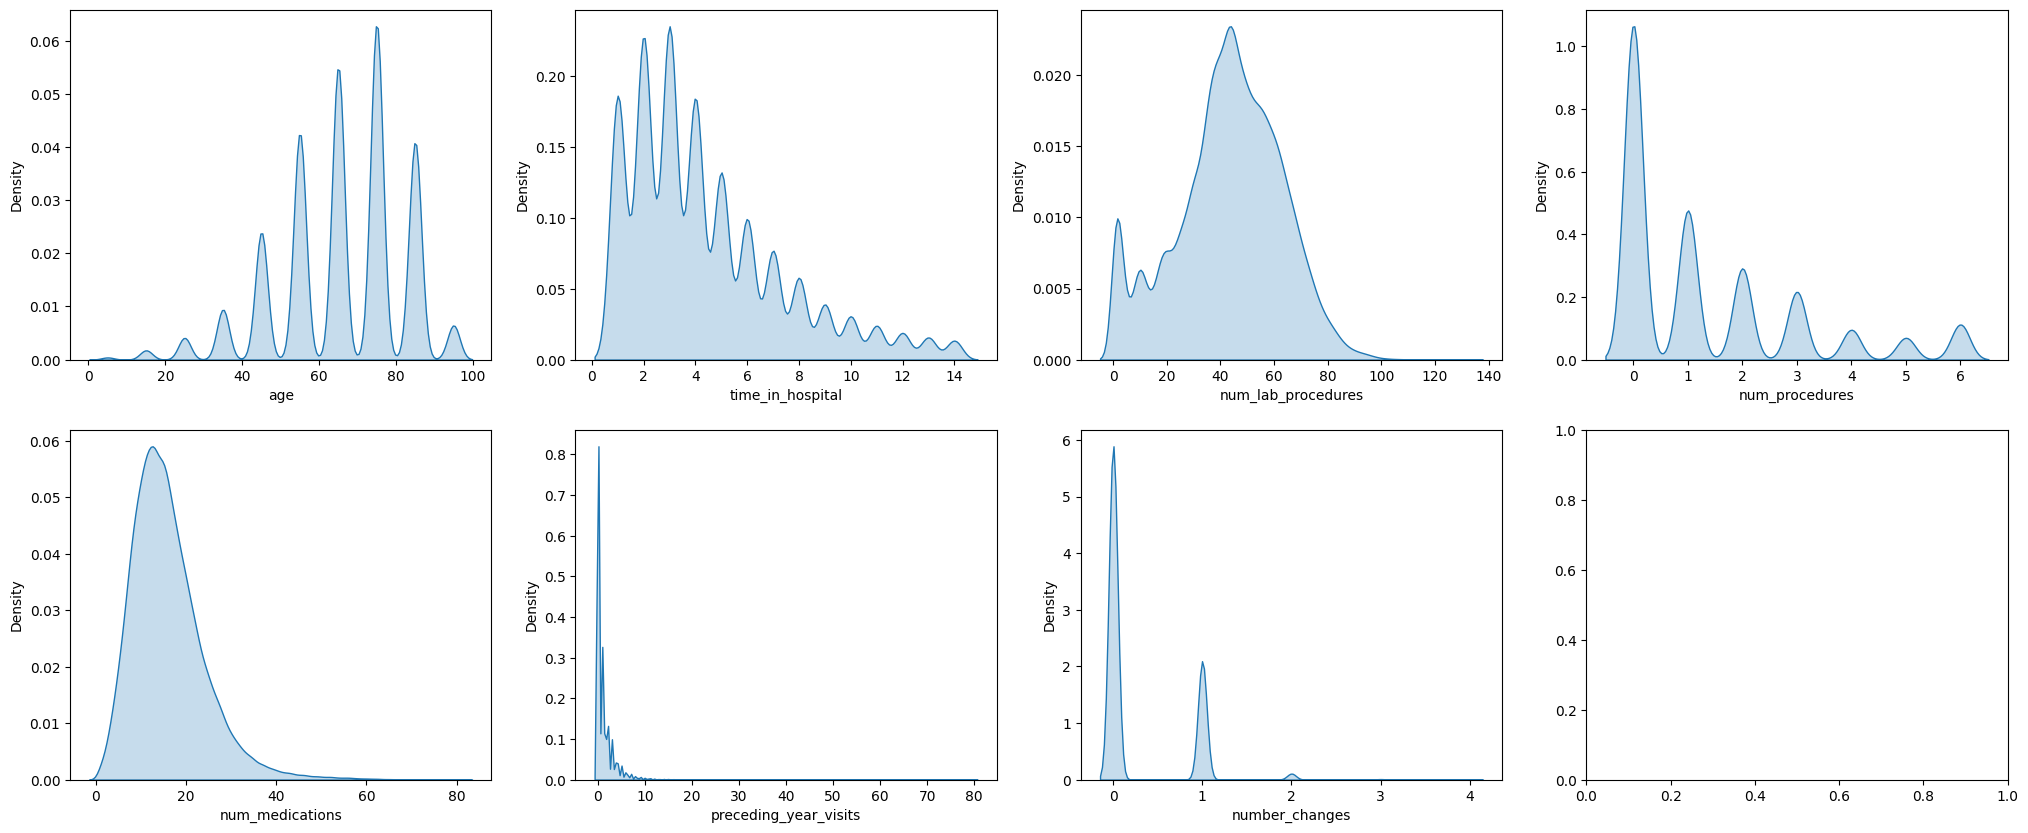

In [212]:
fig,ax=plt.subplots(2,4,figsize=(25,10))
ax=ax.flatten()
j=0
for i in num_cols:    
    sns.kdeplot(df[i],ax=ax[j],shade=True)
    plt.rc('legend', fontsize=15) 
    j=j+1
plt.show()

In [213]:
#Number of outliers
for i in num_cols:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3-q1

    UL = q3 + (1.5 * iqr)
    LL = q1 - (1.5 * iqr)
    print(i,df[(df[i]>UL) | (df[i]<LL)].count()[i])
    #print(X[(X[i]>UL) | (X[i]<LL)][i])

age 840
time_in_hospital 2103
num_lab_procedures 119
num_procedures 4675
num_medications 2382
preceding_year_visits 4299
number_changes 111


The data is not normally distributed and has few outliers, but we will normalize later

In [214]:
# Fill NaN values in the 'max_glu_serum' column with 'None'
df['max_glu_serum'].fillna('None', inplace=True)

In [215]:
df.dtypes

age                           int64
discharge_disposition_id     object
admission_source_id          object
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
diag_1                       object
diag_2                       object
diag_3                       object
max_glu_serum                object
metformin                     int64
repaglinide                   int64
glimepiride                   int64
glipizide                     int64
pioglitazone                  int64
insulin                       int64
diabetesMed                   int64
readmitted                    int32
preceding_year_visits         int64
number_changes              float64
insulin_treatment            object
dtype: object

In [216]:
# Identify object columns
object_cols = df.select_dtypes(include=['object']).columns

In [217]:
# Identify object columns
object_cols = df.select_dtypes(include=['object']).columns

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode object columns
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Display the DataFrame to verify the changes
print(df)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [218]:
# Get the count of null values from each column
null_counts = df.isnull().sum()

# Display the count of null values
print(null_counts)


age                         0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
diag_1                      0
diag_2                      0
diag_3                      0
max_glu_serum               0
metformin                   0
repaglinide                 0
glimepiride                 0
glipizide                   0
pioglitazone                0
insulin                     0
diabetesMed                 0
readmitted                  0
preceding_year_visits       0
number_changes              0
insulin_treatment           0
dtype: int64


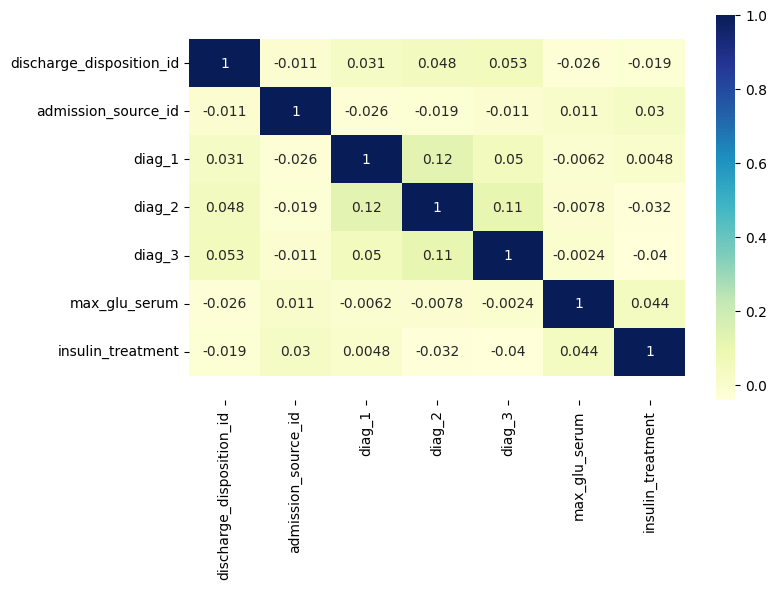

In [219]:
plt.figure(figsize=(8,5))
corr=df[object_cols].corr()
sns.heatmap(corr,annot=True,cmap='YlGnBu')
b,t=plt.ylim()
plt.ylim(b+0.5,t-0.5)
plt.show()

In [220]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(df[object_cols].values,i) for i in range(df[object_cols].shape[1])]
vif['feature']=df[object_cols].columns
vif=vif.sort_values('VIF',ascending=False)
vif

,VIF,feature
5,6.275759,max_glu_serum
6,2.771576,insulin_treatment
2,2.413188,diag_1
3,2.149896,diag_2
4,2.130574,diag_3
1,1.638190,admission_source_id
0,1.432543,discharge_disposition_id


### Saving the data frame

In [222]:
df.head(5)

,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,max_glu_serum,metformin,repaglinide,glimepiride,glipizide,pioglitazone,insulin,diabetesMed,readmitted,preceding_year_visits,number_changes,insulin_treatment
0,5,3,2,1,41,0,1,3,14,14,2,-2,-2,-2,-2,-2,-2,0,0,0,0.0,2
1,15,0,0,3,59,0,18,5,3,5,2,-2,-2,-2,-2,-2,1,1,0,0,1.0,1
2,25,0,0,2,11,5,13,15,3,6,2,-2,-2,-2,0,-2,-2,1,0,3,0.0,3
3,35,0,0,2,44,1,16,8,3,1,2,-2,-2,-2,-2,-2,1,1,0,0,1.0,1
4,45,0,0,1,51,0,8,12,12,3,2,-2,-2,-2,0,-2,0,1,0,0,0.0,0


In [223]:
df.to_csv('Data-set-cleaned.csv', index=False)